# Notebook error analysis 

## Refining error types - Vectorization and clustering method selection


use a subset of whole GitHub error dataset -> PL=python & ename == ValueError

In [1]:
import pandas as pd 
import cluster_util

df2_err = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_all_p3.csv', encoding='utf-8')
df2_err = df2_err[df2_err['language']=='python'][['fname','ename','evalue','traceback']]

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Preprocess the whole dataset - tokenize

In [2]:
df2_err['evalue_tokenized'] = df2_err['evalue'].apply(cluster_util.preprocess_text)

In [4]:
df2_err.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evaluetokenized.csv", index=False, encoding='utf-8')

### 2. Clustering Value errors

load tokenized error dataset, evalue_tokenized

In [1]:
import pandas as pd 
import cluster_util

df2_err = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_all_p3_evaluetokenized.csv', encoding='utf-8')
df2_err_ename = df2_err[df2_err['ename']=='ValueError'][['ename','evalue','evalue_tokenized']]
err_descs = df2_err_ename['evalue_tokenized'].values.astype('U')

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.1 Vectorization
##### 1. tfidf
too high dimension (18148, 7791)

In [12]:
X_tfidf = cluster_util.vectorizer_tfidf(err_descs)
X_tfidf.shape

(18148, 7791)

In [15]:
import numpy as np

with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_tfidf.txt', 'wb') as f:
    np.save(f, X_tfidf)

##### 2. sentence transformers

https://github.com/UKPLab/sentence-transformers

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

sentence to vector (18148, 384)

2 embeddings with different preprocessing

In [59]:
X_transformers = cluster_util.vectorizer_sentence2vec(err_descs)
X_transformers.shape

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(18148, 384)

In [60]:
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_transformers.txt', 'wb') as f:
    np.save(f, X_transformers)

In [6]:
df2_err_ename['evalue_tokenized_transformer'] = df2_err_ename['evalue'].apply(cluster_util.preprocess_text_transformer)
err_descs1 = df2_err_ename['evalue_tokenized_transformer'].values.astype('U')

X_transformers1 = cluster_util.vectorizer_sentence2vec(err_descs1)

with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_transformers_1.txt', 'wb') as f:
    np.save(f, X_transformers1)

##### 3. word embeddings - GloVe

Turn sentences to vectors via word embeddings by taking the mean/sum of all word embeddings of the sentence

using GloVe (18148, 200)

In [24]:
glove_vectors = cluster_util.load_glove("C:/Users/yirwa29/Downloads/Dataset-Nb/glove.6B/glove.6B.200d.txt")
X_glove = np.array([cluster_util.vectorizer_word2vec(xi, glove_vectors, 200) for xi in err_descs])
X_glove.shape

Loaded 400000 word vectors from GloVe.


(18148, 200)

In [25]:
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_glove.txt', 'wb') as f:
    np.save(f, X_glove)

### 2.2 Clustering with vectorized error values


In [ ]:
import pandas as pd
import numpy as np 
import cluster_util

path = 'C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_valueerror.csv'

##### 1. tfidf

In [1]:
df2_err_ename = pd.read_csv(path, encoding='utf-8')
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_tfidf.txt', 'rb') as f:
    X_tfidf = np.load(f)

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
## kmeans

In [2]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_tfidf, K_range = K_range)

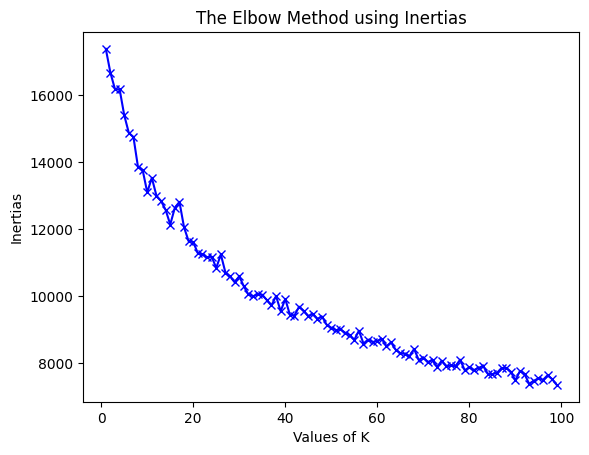

In [3]:
import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [4]:
num_clusters = 60
res = cluster_util.cluster_kmeans(X_tfidf, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

cluster 0 has 978 samples
                                                  evalue  cluster
11243         invalid literal for int() with base 10: ''        0
2348   invalid literal for int() with base 10: '1 2 3...        0
16129      invalid literal for int() with base 10: 'wc:'        0
16595      invalid literal for int() with base 10: '96a'        0
16508     invalid literal for int() with base 10: '20.0'        0
4347         invalid literal for int() with base 10: 's'        0
3291   invalid literal for int() with base 10: '00000...        0
8114       invalid literal for int() with base 10: '10p'        0
1985    invalid literal for int() with base 10: '10,342'        0
4216       invalid literal for int() with base 10: '31a'        0


cluster 1 has 1031 samples
                                                  evalue  cluster
17497  operands could not be broadcast together with ...        1
12117  operands could not be broadcast together with ...        1
6815   operands could

In [6]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_tfidf"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

In [ ]:
## dbscan

In [8]:
eps_tfidf = cluster_util.epsilon_search_dbscan(X_tfidf)
print(eps_tfidf)
res = cluster_util.cluster_dbscan(X_tfidf, eps=eps_tfidf, min_samples=30)

0.6945816409918291
Estimated no. of clusters: 78
Estimated no. of noise points: 8004


In [9]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

cluster 0 has 309 samples
                                                  evalue  cluster
15627  x and y must have same first dimension, but ha...        0
905    x and y must have same first dimension, but ha...        0
2242   x and y must have same first dimension, but ha...        0
13306  x and y must have same first dimension, but ha...        0
210    x and y must have same first dimension, but ha...        0
10872  x and y must have same first dimension, but ha...        0
5587   x and y must have same first dimension, but ha...        0
480    x and y must have same first dimension, but ha...        0
5371   x and y must have same first dimension, but ha...        0
16889  x and y must have same first dimension, but ha...        0


cluster 1 has 415 samples
                                        evalue  cluster
488     too many values to unpack (expected 3)        1
3582    too many values to unpack (expected 1)        1
14854                too many values to unpack      

In [10]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_tfidf"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

In [ ]:
## OPTICS

In [11]:
res = cluster_util.cluster_optics(X_tfidf, min_samples = 30)

Estimated no. of clusters: 96
Estimated no. of noise points: 7792


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [12]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

cluster 0 has 309 samples
                                                  evalue  cluster
4866   x and y must have same first dimension, but ha...        0
10275  x and y must have same first dimension, but ha...        0
17055  x and y must have same first dimension, but ha...        0
6075   x and y must have same first dimension, but ha...        0
1306   x and y must have same first dimension, but ha...        0
6130   x and y must have same first dimension, but ha...        0
15215  x and y must have same first dimension, but ha...        0
3528   x and y must have same first dimension, but ha...        0
16895  x and y must have same first dimension, but ha...        0
17424  x and y must have same first dimension, but ha...        0


cluster 1 has 103 samples
                                evalue  cluster
6371     x and y must be the same size        1
4066     x and y must be the same size        1
16241    x and y must be the same size        1
9262     x and y must be the

In [13]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_tfidf"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

In [14]:
df2_err_ename

,ename,evalue,evalue_tokenized,evalue_tokenized_transformer,cluster_km_tfidf,cluster_dbscan_tfidf,cluster_optics_tfidf
0,ValueError,"x and y must have same first dimension, but ha...",x and y must have same first dimension but hav...,"x and y must have same first dimension, but ha...",58,0,0
1,ValueError,too many values to unpack (expected 3),too many values to unpack expected,too many values to unpack (expected 3),50,1,36
2,ValueError,Field names cannot start with an underscore: '...,field names can not start with an underscore,field names cannot start with an underscore: '...,51,-1,-1
3,ValueError,in user code:\n\n /home/arun/.local/lib/pyt...,in user code return self iterator outputs args...,in user code:\n\n /home/arun/.local/lib/pyt...,34,2,-1
4,ValueError,"x and y must have same first dimension, but ha...",x and y must have same first dimension but hav...,"x and y must have same first dimension, but ha...",58,0,0
...,...,...,...,...,...,...,...
18143,ValueError,shape mismatch: objects cannot be broadcast to...,shape mismatch objects can not be broadcast to...,shape mismatch: objects cannot be broadcast to...,42,21,61
18144,ValueError,cannot handle a non-unique multi-index!,can not handle a non-unique multi-index,cannot handle a non-unique multi-index!,51,-1,-1
18145,ValueError,lat already exists as coordinate or variable n...,lat already exists as coordinate or variable name,lat already exists as coordinate or variable n...,51,-1,-1
18146,ValueError,Unknown label type: 'continuous',unknown label type continuous,unknown label type: 'continuous',54,37,40


##### 2. sentence transformers

In [15]:
df2_err_ename = pd.read_csv(path, encoding='utf-8')
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_transformers.txt', 'rb') as f:
    X_transformers = np.load(f)
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_transformers_1.txt', 'rb') as f:
    X_transformers1 = np.load(f)

In [16]:
## kmeans

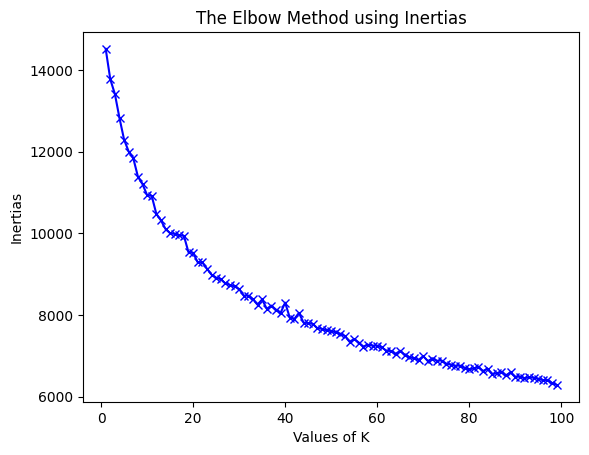

In [67]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_transformers, K_range = K_range) # X_transformers1

import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [17]:
num_clusters = 60
res = cluster_util.cluster_kmeans(X_transformers, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

cluster 0 has 980 samples
                                                  evalue  cluster
9476       invalid literal for int() with base 10: 'abc'        0
17975     invalid literal for int() with base 10: '7.93'        0
4759     invalid literal for int() with base 10: 'semih'        0
7666         invalid literal for int() with base 10: 's'        0
12421  invalid literal for int() with base 10: '46tni...        0
11337         invalid literal for int() with base 10: ''        0
2570       invalid literal for int() with base 10: 'two'        0
4487       invalid literal for int() with base 10: '5.5'        0
9727          invalid literal for int() with base 10: ''        0
9587        invalid literal for int() with base 10: '1a'        0


cluster 1 has 904 samples
                                                  evalue  cluster
13400  could not convert string to float: 'Another Tr...        1
17633                could not convert string to float:         1
292         could not 

In [18]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_transformers"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

In [19]:
# transformer1
num_clusters = 60
res = cluster_util.cluster_kmeans(X_transformers1, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

cluster 0 has 984 samples
                                                  evalue  cluster
8509     invalid literal for int() with base 10: 'dfghj'        0
8432       invalid literal for int() with base 10: '3.4'        0
10784        invalid literal for long() with base 10: ''        0
8651    invalid literal for int() with base 10: 'Closed'        0
16040  invalid literal for int() with base 10: 'Hello...        0
544        invalid literal for int() with base 10: 'foo'        0
2118         invalid literal for int() with base 10: 'a'        0
9561   invalid literal for int() with base 10: 'local...        0
4911       invalid literal for int() with base 10: 'Inf'        0
7325         invalid literal for int() with base 10: 'a'        0


cluster 1 has 213 samples
                                                  evalue  cluster
13309   Not enough indexers for scalar access (setting)!        1
11069          20130101 not present in input data index.        1
8741                In

In [20]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_transformers1"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

In [21]:
## dbscan

In [22]:
eps_transformers = cluster_util.epsilon_search_dbscan(X_transformers)
print(eps_transformers)
res = cluster_util.cluster_dbscan(X_transformers, eps=eps_transformers, min_samples=30)

0.6461223470548229
Estimated no. of clusters: 73
Estimated no. of noise points: 7340


In [23]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

cluster 0 has 309 samples
                                                  evalue  cluster
16586  x and y must have same first dimension, but ha...        0
4323   x and y must have same first dimension, but ha...        0
10157  x and y must have same first dimension, but ha...        0
13880  x and y must have same first dimension, but ha...        0
10961  x and y must have same first dimension, but ha...        0
914    x and y must have same first dimension, but ha...        0
16680  x and y must have same first dimension, but ha...        0
15091  x and y must have same first dimension, but ha...        0
4319   x and y must have same first dimension, but ha...        0
5009   x and y must have same first dimension, but ha...        0


cluster 1 has 722 samples
                                                evalue  cluster
14951  not enough values to unpack (expected 4, got 3)        1
8411   not enough values to unpack (expected 3, got 2)        1
6233            too many val

In [24]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_transformers"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

In [25]:
# transformer 1
eps_transformers1 = cluster_util.epsilon_search_dbscan(X_transformers1)
print(eps_transformers1)
res = cluster_util.cluster_dbscan(X_transformers1, eps=eps_transformers1, min_samples=30)

0.4740334847022414
Estimated no. of clusters: 65
Estimated no. of noise points: 9441


In [26]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

cluster 0 has 702 samples
                                                evalue  cluster
14113  not enough values to unpack (expected 3, got 2)        0
4473            too many values to unpack (expected 2)        0
15020  not enough values to unpack (expected 4, got 0)        0
14190  not enough values to unpack (expected 2, got 1)        0
17048  not enough values to unpack (expected 2, got 0)        0
5176            too many values to unpack (expected 2)        0
4429   not enough values to unpack (expected 4, got 3)        0
4615            too many values to unpack (expected 3)        0
13501           too many values to unpack (expected 9)        0
2906            too many values to unpack (expected 2)        0


cluster 1 has 166 samples
                                                  evalue  cluster
10814  in user code:\n\n    C:\Users\merel\AppData\Ro...        1
11216  in user code:\n\n    /Users/rob/opt/anaconda3/...        1
6315   in user code:\n\n    /Users/lipengyua

In [27]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_transformers1"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

In [28]:
## OPTICS

In [29]:
res = cluster_util.cluster_optics(X_transformers, min_samples = 30)

Estimated no. of clusters: 91
Estimated no. of noise points: 8338


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [30]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(49, df2_err_ename[['evalue','cluster']])

cluster 0 has 283 samples
                                                  evalue  cluster
5426   x and y must have same first dimension, but ha...        0
3149   x and y must have same first dimension, but ha...        0
16346  x and y must have same first dimension, but ha...        0
18135  x and y must have same first dimension, but ha...        0
13277  x and y must have same first dimension, but ha...        0
17389  x and y must have same first dimension, but ha...        0
10339  x and y must have same first dimension, but ha...        0
15443  x and y must have same first dimension, but ha...        0
7957   x and y must have same first dimension, but ha...        0
10299  x and y must have same first dimension, but ha...        0


cluster 1 has 47 samples
                                                  evalue  cluster
16051  Dimensions must be equal, but are 20 and 10 fo...        1
4107   Shapes must be equal rank, but are 1 and 4 for...        1
192    Dimensions must 

In [31]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_transformers"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

In [32]:
# transformer 1
res = cluster_util.cluster_optics(X_transformers1, min_samples = 30)

Estimated no. of clusters: 96
Estimated no. of noise points: 10735


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [33]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

cluster 0 has 310 samples
                                                  evalue  cluster
17556  x and y must have same first dimension, but ha...        0
9280   x and y must have same first dimension, but ha...        0
16398  x and y must have same first dimension, but ha...        0
6410   x and y must have same first dimension, but ha...        0
2409   x and y must have same first dimension, but ha...        0
11483  x and y must have same first dimension, but ha...        0
12596  x and y must have same first dimension, but ha...        0
13484             x and y must have same first dimension        0
10783  x and y must have same first dimension, but ha...        0
6408   x and y must have same first dimension, but ha...        0


cluster 1 has 107 samples
                              evalue  cluster
12207  x and y must be the same size        1
1991   x and y must be the same size        1
10897  x and y must be the same size        1
11365  x and y must be the same size

In [34]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_transformers1"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

##### 3. word embeddings - GloVe

In [35]:
df2_err_ename = pd.read_csv(path, encoding='utf-8')
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_glove.txt', 'rb') as f:
    X_glove = np.load(f)

In [36]:
## kmeans

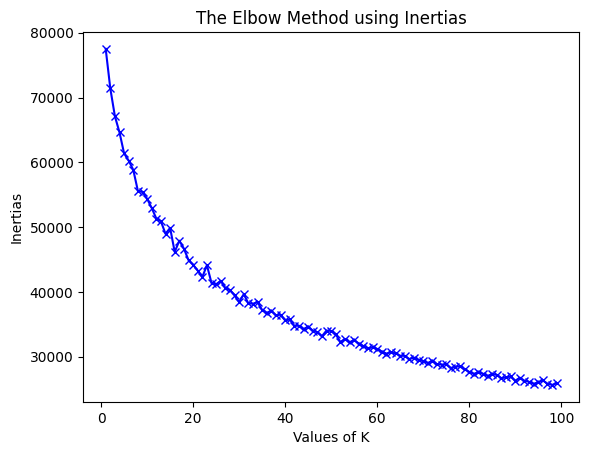

In [28]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_glove, K_range = K_range)

import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [37]:
num_clusters = 60
res = cluster_util.cluster_kmeans(X_glove, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

cluster 0 has 982 samples
                                                  evalue  cluster
13685      invalid literal for int() with base 10: 'one'        0
9571     invalid literal for int() with base 10: 'count'        0
4568      invalid literal for int() with base 10: 'data'        0
3290      invalid literal for int() with base 10: 'five'        0
1128          invalid literal for int() with base 10: ''        0
14797         invalid literal for int() with base 10: ''        0
6803          invalid literal for int() with base 10: ''        0
14207  invalid literal for int() with base 10: ' 2 3 4 '        0
2564        invalid literal for int() with base 10: '-f'        0
11246  invalid literal for int() with base 10: '/User...        0


cluster 1 has 410 samples
                                                  evalue  cluster
13925  Error when checking target: expected dense_2 t...        1
3639   Error when checking : expected embedding_1_inp...        1
17493  Error when chec

In [38]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_glove"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

In [39]:
## dbscan

In [40]:
eps_glove = cluster_util.epsilon_search_dbscan(X_glove)
print(eps_glove)
res = cluster_util.cluster_dbscan(X_glove, eps=eps_glove, min_samples=30)

1.0540820531049555
Estimated no. of clusters: 71
Estimated no. of noise points: 7039


In [41]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

cluster 0 has 435 samples
                                                  evalue  cluster
12471  x and y must have same first dimension, but ha...        0
10474                      x and y must be the same size        0
914    x and y must have same first dimension, but ha...        0
17284                      x and y must be the same size        0
466                        x and y must be the same size        0
12736             x and y must have same first dimension        0
13889  x and y must have same first dimension, but ha...        0
14894  x and y can be no greater than 2-D, but have s...        0
13709  x and y must have same first dimension, but ha...        0
5043   x and y must have same first dimension, but ha...        0


cluster 1 has 415 samples
                                       evalue  cluster
10484  too many values to unpack (expected 2)        1
16499  too many values to unpack (expected 3)        1
5196   too many values to unpack (expected 2)        1


In [42]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_glove"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

In [43]:
## OPTICS

In [44]:
res = cluster_util.cluster_optics(X_glove, min_samples = 30)

Estimated no. of clusters: 97
Estimated no. of noise points: 8183


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [45]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

cluster 0 has 309 samples
                                                  evalue  cluster
6410   x and y must have same first dimension, but ha...        0
13997             x and y must have same first dimension        0
1613   x and y must have same first dimension, but ha...        0
5371   x and y must have same first dimension, but ha...        0
7920   x and y must have same first dimension, but ha...        0
10407  x and y must have same first dimension, but ha...        0
12624  x and y must have same first dimension, but ha...        0
4587   x and y must have same first dimension, but ha...        0
18137  x and y must have same first dimension, but ha...        0
905    x and y must have same first dimension, but ha...        0


cluster 1 has 96 samples
                              evalue  cluster
7035   x and y must be the same size        1
757    x and y must be the same size        1
6281   x and y must be the same size        1
963    x and y must be the same size 

In [46]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_glove"})
df2_err_ename.to_csv(path, index=False, encoding='utf-8')

#### evaluate vectorization and clustering methods

In [48]:
df2_err_ename.columns

Index(['ename', 'evalue', 'evalue_tokenized', 'evalue_tokenized_transformer',
       'cluster_km_tfidf', 'cluster_dbscan_tfidf', 'cluster_optics_tfidf',
       'cluster_km_transformers', 'cluster_km_transformers1',
       'cluster_dbscan_transformers', 'cluster_dbscan_transformers1',
       'cluster_optics_transformers', 'cluster_optics_transformers1',
       'cluster_km_glove', 'cluster_dbscan_glove', 'cluster_optics_glove'],
      dtype='object')

In [1]:
import pandas as pd
import numpy as np
import cluster_util

path = 'C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_valueerror.csv'

df2_err_ename = pd.read_csv(path, encoding='utf-8')
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_tfidf.txt', 'rb') as f:
    X_tfidf = np.load(f)
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_transformers.txt', 'rb') as f:
    X_transformers = np.load(f)
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_transformers1.txt', 'rb') as f:
    X_transformers1 = np.load(f)
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_glove.txt', 'rb') as f:
    X_glove = np.load(f)

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
arr_eval = np.zeros((3,4))
name_cols = ['tfidf','word2vec','transformer','transformer1']
name_rows = ['kmeans','dbscan','optics']

#ss_km_tfidf
arr_eval[0,0] = cluster_util.eval_cluster_silhouette(X_tfidf, df2_err_ename['cluster_km_tfidf'])
#ss_km_glove
arr_eval[0,1] = cluster_util.eval_cluster_silhouette(X_glove, df2_err_ename['cluster_km_glove'])
#ss_km_transformers
arr_eval[0,2] = cluster_util.eval_cluster_silhouette(X_transformers, df2_err_ename['cluster_km_transformers'])
#ss_km_transformers1
arr_eval[0,3] = cluster_util.eval_cluster_silhouette(X_transformers1, df2_err_ename['cluster_km_transformers1'])

#ss_dbscan_tfidf
arr_eval[1,0] = cluster_util.eval_cluster_silhouette(X_tfidf[df2_err_ename['cluster_dbscan_tfidf']!=-1], 
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_tfidf']!=-1, 'cluster_dbscan_tfidf'])
#ss_dbscan_glove
arr_eval[1,1] = cluster_util.eval_cluster_silhouette(X_glove[df2_err_ename['cluster_dbscan_glove']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_glove']!=-1, 'cluster_dbscan_glove'])
#ss_dbscan_transformers
arr_eval[1,2] = cluster_util.eval_cluster_silhouette(X_transformers[df2_err_ename['cluster_dbscan_transformers']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_transformers']!=-1, 'cluster_dbscan_transformers'])
#ss_dbscan_transformers1
arr_eval[1,3] = cluster_util.eval_cluster_silhouette(X_transformers1[df2_err_ename['cluster_dbscan_transformers1']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_transformers1']!=-1, 'cluster_dbscan_transformers1'])
#ss_optics_tfidf
arr_eval[2,0] = cluster_util.eval_cluster_silhouette(X_tfidf[df2_err_ename['cluster_optics_tfidf']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_tfidf']!=-1, 'cluster_optics_tfidf'])
#ss_optics_glove
arr_eval[2,1] = cluster_util.eval_cluster_silhouette(X_glove[df2_err_ename['cluster_optics_glove']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_glove']!=-1, 'cluster_optics_glove'])
#ss_optics_transformers
arr_eval[2,2] = cluster_util.eval_cluster_silhouette(X_transformers[df2_err_ename['cluster_optics_transformers']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_transformers']!=-1, 'cluster_optics_transformers'])
#ss_optics_transformers1
arr_eval[2,3] = cluster_util.eval_cluster_silhouette(X_transformers1[df2_err_ename['cluster_optics_transformers1']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_transformers1']!=-1, 'cluster_optics_transformers1'])

In [55]:
df_eval = pd.DataFrame(arr_eval, index=name_rows, columns=name_cols)
df_eval

,tfidf,word2vec,transformer,transformer1
kmeans,0.389039,0.357720,0.386167,0.243425
dbscan,0.901757,0.796417,0.804534,0.660009
optics,0.904882,0.944358,0.924152,0.751302


In [56]:
df_eval.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_valueerror_eval.csv", index=False, encoding='utf-8')